In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import pymc as mc
import numpy as np

import h5py

from vpfits import *

In [13]:
line = 1036.

# use hydrogen spectrum for this as it is faster
data = h5py.File('data/spectrum_pygad_CII1036.h5', 'r')

wavelength = data['wavelength'][:]
flux = data['flux'][:]
noise = data['noise'][:]
taus = data['tau'][:]

nu = constants['c']['value'] / wavelength 

In [14]:
# Identify regions in the spectrum to fit

min_region_width = 2
regions, region_pixels = compute_detection_regions(wavelength, taus, flux, noise,
                                          min_region_width=min_region_width)

Computing detection regions...
Found 4 detection regions.


Computing detection regions...
Found 4 detection regions.
Setting initial number of lines to: 1
Old BIC value of -8.10 is greater than the current -13.34.
Increasing the number of lines to: 3
Old BIC value of -13.34 is greater than the current -54.18.
Increasing the number of lines to: 4
Old BIC value of -54.18 is greater than the current -82.14.
Increasing the number of lines to: 5
Old BIC value of -82.14 is greater than the current -84.72.
Increasing the number of lines to: 6
BIC increased with increasing the line number, stopping.
Final n=5.


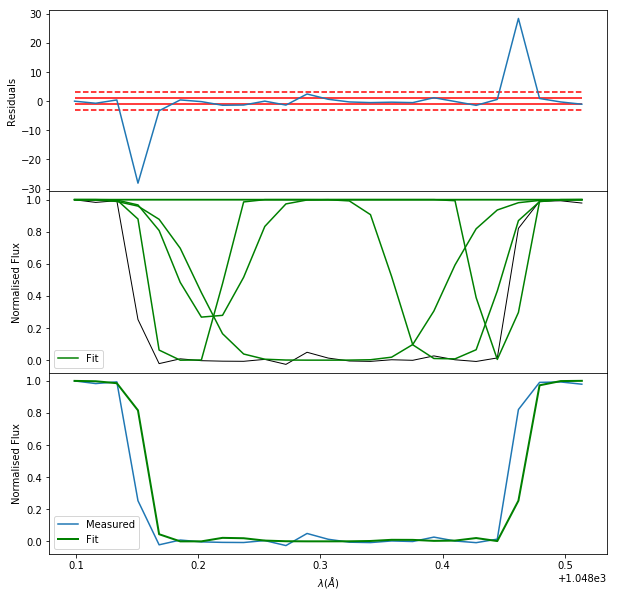

Reduced chi squared is 162.711693441
Setting initial number of lines to: 1
Old BIC value of -27.28 is greater than the current -51.68.
Increasing the number of lines to: 3
Old BIC value of -51.68 is greater than the current -173.36.
Increasing the number of lines to: 4
Old BIC value of -173.36 is greater than the current -193.39.
Reduced Chi squared is less than 1.5
Final n=4


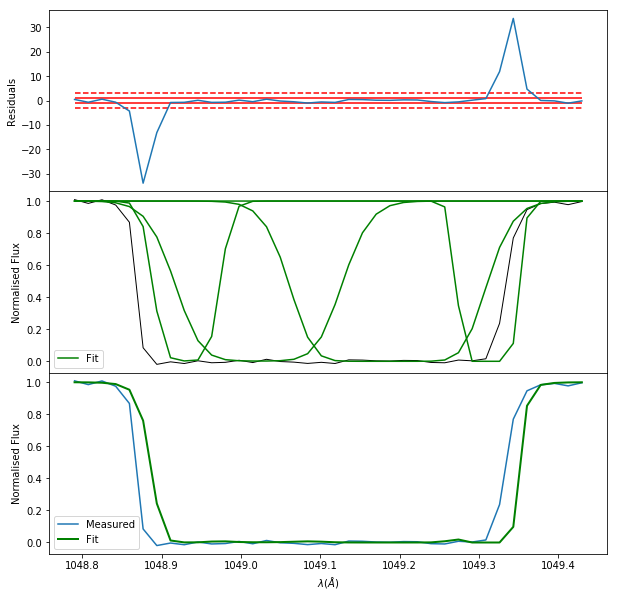

Reduced chi squared is 210.773840629
Setting initial number of lines to: 1
Old BIC value of -10.62 is greater than the current -22.04.
Increasing the number of lines to: 3
Old BIC value of -22.04 is greater than the current -41.68.
Increasing the number of lines to: 4
Old BIC value of -41.68 is greater than the current -59.36.
Reduced Chi squared is less than 1.5
Final n=4


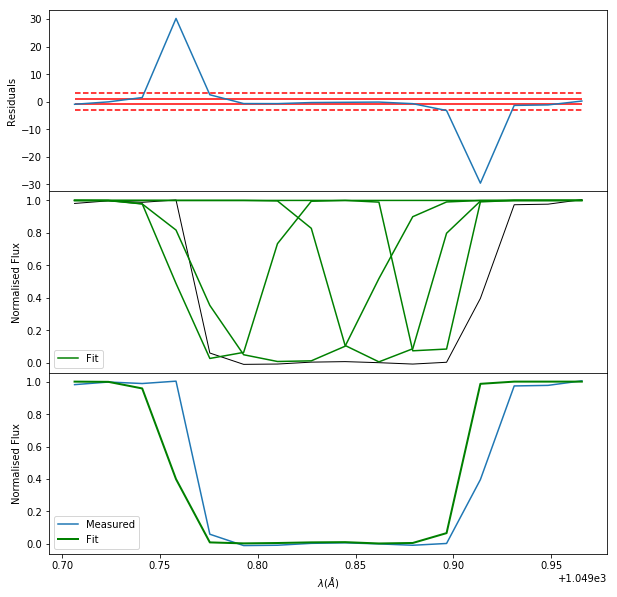

Reduced chi squared is 258.08799567
Setting initial number of lines to: 1
BIC increased with increasing the line number, stopping.
Final n=1.


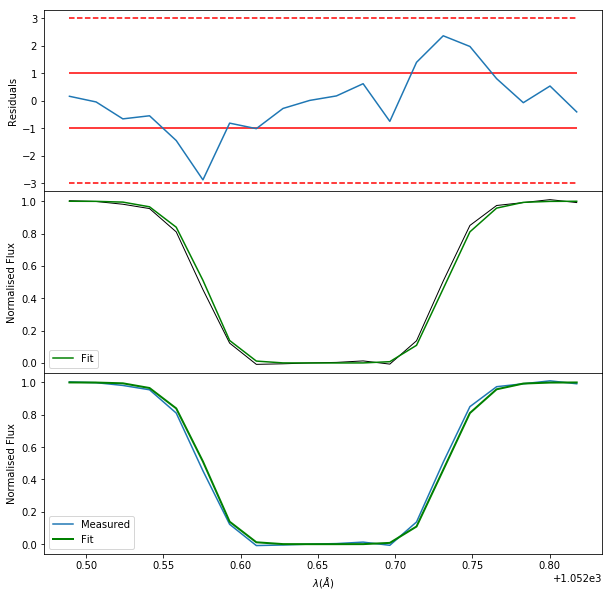

Reduced chi squared is 4.60762214963


In [15]:
wavelength_array = wavelength
frequency_array = nu
tau_array = taus
flux_array = flux
noise_array = noise

frequency_array = constants['c']['value'] / (wavelength_array*1.e-10)
regions, region_pixels = compute_detection_regions(wavelength_array, tau_array, flux_array, noise_array, min_region_width=2)

flux_model = {'total': np.ones(len(flux_array)), 'chi_squared': np.zeros(len(regions))}

j = 0
for start, end in region_pixels[0:]:
    fluxes = flux_array[start:end]
    noise = noise_array[start:end]
    waves = wavelength_array[start:end]
    nu = frequency_array[start:end]
    taus = tau_array[start:end]


    # make initial guess for number of lines in a region
    n = estimate_n(fluxes)

    # number of degrees of freedom = number of data points + number of parameters
    freedom = len(fluxes) + 3*n

    # fit the region by minimising BIC and chi squared
    fit = region_fit(nu, fluxes, n, noise, freedom, voigt=False, chi_limit=1.5)

    # evaluate overall chi squared
    n = len(fit.estimated_profiles)
    freedom = len(fluxes) + 3*n
    
    fit.plot(waves, fluxes, n=n, start_pix=start, end_pix=end)

    flux_model['chi_squared'][j] = fit.ReducedChisquared(fluxes, fit.total.value, noise, freedom)

    print 'Reduced chi squared is {}'.format(flux_model['chi_squared'][j])

    # if chi squared is sufficiently small, stop there. If not, repeat the region fitting
    #if flux_model['chi_squared'][j] < 1.5:
    #    break
            
    j += 1


Setting initial number of lines to: 1
Old BIC value of -6.76 is greater than the current -10.89.
Increasing the number of lines to: 3
Old BIC value of -10.89 is greater than the current -82.55.
Increasing the number of lines to: 4
Old BIC value of -82.55 is greater than the current -106.61.
Reduced Chi squared is less than 1.5
Final n=4


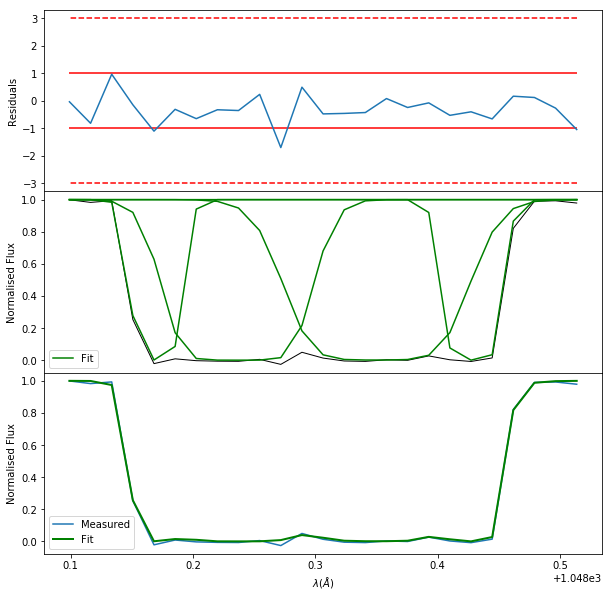

1.0358353933236277
Setting initial number of lines to: 1
Old BIC value of -25.15 is greater than the current -38.13.
Increasing the number of lines to: 3
Old BIC value of -38.13 is greater than the current -180.93.
Increasing the number of lines to: 4
Old BIC value of -180.93 is greater than the current -199.39.
Reduced Chi squared is less than 1.5
Final n=4


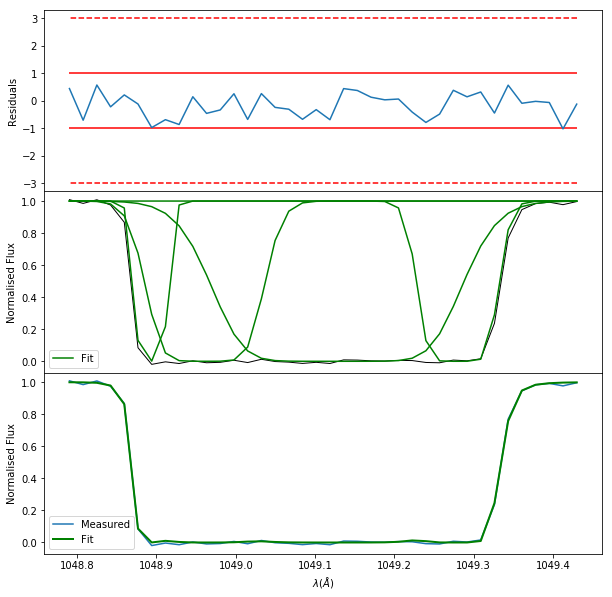

0.6941428017486205
Setting initial number of lines to: 1
Old BIC value of -10.77 is greater than the current -44.46.
Increasing the number of lines to: 3
Old BIC value of -44.46 is greater than the current -66.19.
Reduced Chi squared is less than 1.5
Final n=3


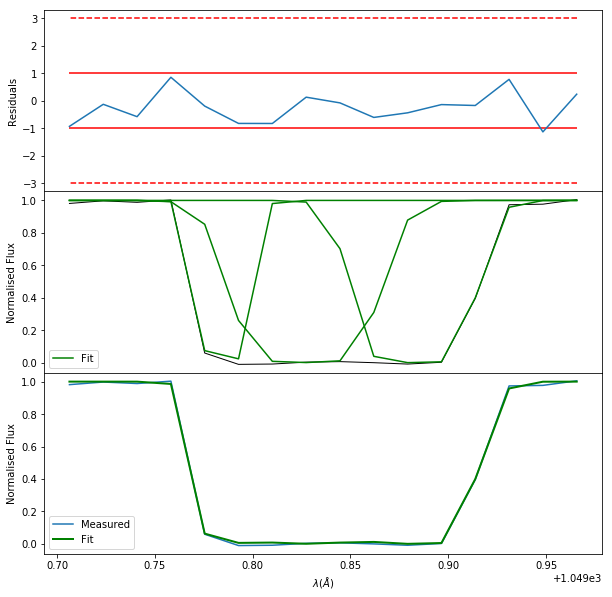

0.9487101459531903
Setting initial number of lines to: 1
BIC increased with increasing the line number, stopping.
Final n=1.


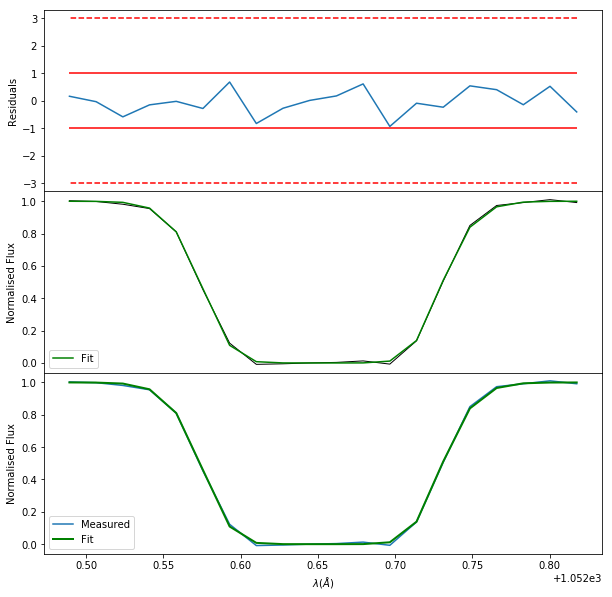

0.6893774078983083


In [12]:
for start, end in region_pixels:

    wavelengths = np.flip(wavelength[start:end], 0)
    fluxes = np.flip(flux[start:end], 0)
    nu_use = np.flip(nu[start:end], 0)
    noises = np.flip(noise[start:end], 0)

    for i in range(10):
        n = estimate_n(fluxes)
        freedom = len(nu_use) + n*3
        vp = region_fit(nu_use, fluxes, n, noises, freedom, chi_limit=1.5)
        n = len(vp.estimated_profiles)
        freedom = len(nu_use) + n*3
        chi = vp.ReducedChisquared(fluxes, vp.total.value, noises, freedom)
        vp.plot(wavelengths, fluxes, n=n, start_pix=start, end_pix=end)
        print chi
        if chi < 1.5:
            break